In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from typing import List
import gc
from copy import deepcopy

# Градиентный спуск

In [ ]:
def add_const(X: np.ndarray) -> np.ndarray:
    """
    Функция добавления константы в массив данных

    Inputs:

        X: np.ndarray - Матрица с данными

    Returns:

        np.ndarray Матрица с добавленным столбцом единиц

    """
    return np.hstack((X, np.ones((X.shape[0], 1))))


def Logistic_Regression(X: np.ndarray, w: np.ndarray, eps=0) -> np.ndarray:
    """
    Функция для вычисления предсказаний Логистической регрессии

    Inputs:

        X: np.ndarray- Матрица с данными для которых необходимо выполнить предсказание

        w: np.ndarray - Вектор весов

        eps: np.ndarray - шум, необходимый для генерации обучающих данных. В другое время = 0

    Returns:

        np.ndarray вектор с вероятностями принадлежности к классу с меткой 1

    """
    return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))


def Log_Loss(y_true: np.ndarray, y_pred: np.ndarray, eps=1e-15) -> float:
    """
    LogLoss функция вычисления ошибки бинарной классификации.
    Так как Loss не определен для p = 0 и p = 1, значения вероятности ограничеваются epsilon по формуле max(eps, min(1 - eps, p))

    Inputs:

        y_true: np.ndarray- вектор с истиными метками классов

        y_pred: np.ndarray- вектор с предсказанной вероятностью принадлежности классу с меткой 1

        eps - величина для ограничения вероятностей. default = 1e-15

    Returns:

        значение функции потерь

    """
    preds = np.maximum(
        eps * np.ones(y_pred.shape),
        np.minimum((1 - eps) * np.ones(y_pred.shape), y_pred),
    )
    return (
        -1
        / y_true.shape[0]
        * np.sum(y_true * np.log(preds) + (1 - y_true) * np.log(1 - preds))
    )


def Log_Loss_gradient(
    X: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray
) -> np.ndarray:
    """
    Функция вычисления градиентов функции потерь по весам модели

    Inputs:

        X: np.ndarray - Матрица с данными

        y_true: np.ndarray - вектор с истиными метками классов

        y_pred: np.ndarray- вектор с предсказанной вероятностью принадлежности классу с меткой 1

    Returns:

        np.ndarray со значениями градиентов для весов

    """
    return add_const(X).T.dot((1 - y_true) * y_pred - y_true * (1 - y_pred))


def train_Log_Reg_gradient_method(
    X: np.ndarray, y_true: np.ndarray, w: np.ndarray, num_epoch=100, lr=1e-3
) -> np.ndarray:
    """
    Функция обучения логистической регрессии при помощи градиентного спуска

    Inputs:

        X: np.ndarray - Матрица с данными для обучения

        y_true: np.ndarray - вектор с истиными метками классов

        w: np.ndarray - Вектор начальных весов

        num_epoch - количество эпох в обучении

        lr - скорость обучения

    Returns:

        (Оптимальные веса, история изменения функции потерь)

    """
    loss_history = []
    for i in range(num_epoch):
        y_pred = Logistic_Regression(X, w)
        loss_history.append(Log_Loss(y_true, y_pred))
        grad = Log_Loss_gradient(X, y_true, y_pred)
        w = w - lr * grad
    return w, loss_history

# CMA-ES

In [ ]:
def purecmaes(X, y_true, sigma=0.3, stopfitness=1e-10, stopeval=None, use_mean=True):
    """
    Реализация базового алгоритма CMA-ES на основе официального туториала (https://arxiv.org/pdf/1604.00772.pdf) и официального MatLab кода.
    Обозначения и комментарии сохранены в соотвестсвии с официальным туториалом.
    Мне тоже совершенно не нравятся обозначения

    Inputs:

        X: np.ndarray - Матрица с данными для обучения

        y_true: np.ndarray - вектор с истиными метками классов

    Returns:

        (Оптимальные веса, история изменения функции потерь)

    """
    # --------------------  Initialization --------------------------------
    loss_history = []
    # User defined input parameters
    N = X.shape[1] + 1  # number of objective variables/problem dimension
    xmean = np.random.rand(N)  # objective variables initial point
    sigma = sigma  # coordinate wise standard deviation (step size)
    stopfitness = stopfitness  # stop if fitness < stopfitness (minimization)
    if stopeval is None:
        stopeval = 1e3 * N**2  # stop after stopeval number of function evaluations

    # Strategy parameter setting: Selection
    lambda_ = 4 + int(3 * np.log(N))  # population size, offspring number
    mu = int(lambda_ / 2)  # number of parents/points for recombination
    weights = np.log(mu + 1 / 2) - np.log(
        np.arange(1, mu + 1)
    )  # muXone array for weighted recombination
    weights /= np.sum(weights)  # normalize recombination weights array
    mueff = np.sum(weights) ** 2 / np.sum(
        weights**2
    )  # variance-effectiveness of sum w_i x_i

    # Strategy parameter setting: Adaptation
    cc = (4 + mueff / N) / (N + 4 + 2 * mueff / N)  # time constant for cumulation for C
    cs = (mueff + 2) / (N + mueff + 5)  # t-const for cumulation for sigma control
    c1 = 2 / ((N + 1.3) ** 2 + mueff)  # learning rate for rank-one update of C
    cmu = min(
        1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((N + 2) ** 2 + mueff)
    )  # and for rank-mu update
    damps = 1 + 2 * max(0, np.sqrt((mueff - 1) / (N + 1)) - 1) + cs  # damping for sigma
    # usually close to 1
    # Initialize dynamic (internal) strategy parameters and constants
    pc = np.zeros(N)
    ps = np.zeros(N)  # evolution paths for C and sigma
    B = np.eye(N)  # B defines the coordinate system
    D = np.ones(N)  # diagonal D defines the scaling
    C = B @ np.diag(D**2) @ B.T  # covariance matrix C
    invsqrtC = B @ np.diag(D**-1) @ B.T  # C^-1/2
    eigeneval = 0  # track update of B and D
    chiN = N**0.5 * (1 - 1 / (4 * N) + 1 / (21 * N**2))  # expectation of
    #   ||N(0,I)|| == norm(randn(N,1))
    # -------------------- Generation Loop --------------------------------
    counteval = 0
    while counteval < stopeval:

        # Generate and evaluate lambda offspring
        arx = np.zeros((N, lambda_))
        arfitness = np.zeros(lambda_)
        for k in range(lambda_):
            arx[:, k] = xmean + sigma * B @ (
                D * np.random.standard_normal(N)
            )  # m + sig * Normal(0,C)
            y_pred = Logistic_Regression(X, arx[:, k])
            arfitness[k] = Log_Loss(y_true, y_pred)  # objective function call
            counteval += 1

        # Sort by fitness and compute weighted mean into xmean
        arindex = np.argsort(arfitness)
        xold = xmean.copy()
        xmean = np.dot(arx[:, arindex[:mu]], weights)  # recombination, new mean value
        # Запоминаем лучший лосс на эпохе
        if use_mean:
            y_pred = Logistic_Regression(X, xmean)
            loss_history.append(Log_Loss(y_true, y_pred))
        else:
            y_pred = Logistic_Regression(X, arx[:, arindex[0]])
            loss_history.append(Log_Loss(y_true, y_pred))
        # Cumulation: Update evolution paths
        ps = (1 - cs) * ps + np.sqrt(cs * (2 - cs) * mueff) * np.dot(
            invsqrtC, (xmean - xold)
        ) / sigma
        hsig = np.linalg.norm(ps) / np.sqrt(
            1 - (1 - cs) ** (2 * counteval / lambda_)
        ) / chiN < 1.4 + 2 / (N + 1)
        pc = (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * (
            xmean - xold
        ) / sigma

        # Adapt covariance matrix C
        artmp = (1 / sigma) * (arx[:, arindex[:mu]] - xold[:, np.newaxis])
        C = (
            (1 - c1 - cmu) * C
            + c1 * (np.outer(pc, pc) + (1 - hsig) * cc * (2 - cc) * C)
            + cmu * np.dot(artmp, np.diag(weights) @ artmp.T)
        )
        # Adapt step size sigma
        sigma = sigma * np.exp((cs / damps) * (np.linalg.norm(ps) / chiN - 1))

        # Decomposition of C into B*diag(D.^2)*B' (diagonalization)
        if counteval - eigeneval > lambda_ / (c1 + cmu) / N / 10:  # to achieve O(N^2)
            eigeneval = counteval
            C = np.triu(C) + np.triu(C, 1).T  # enforce symmetry
            D, B = np.linalg.eigh(C)  # eigen decomposition, B==normalized eigenvectors
            D = np.sqrt(D)  # D is a vector of standard deviations now
            invsqrtC = B @ np.diag(D**-1) @ B.T

        # Break, if fitness is good enough or condition exceeds 1e14, better termination methods are advisable
        if arfitness[0] <= stopfitness or np.max(D) > 1e7 * np.min(D):
            break

    # Return best point of last iteration.
    # Notice that xmean is expected to be even better.
    if use_mean:
        xmin = xmean
    else:
        xmin = arx[:, arindex[0]]
    return xmin, loss_history

# PSO

In [ ]:
def PSO(
    data: np.ndarray,
    target: np.ndarray,
    b_low: float,
    b_up: float,
    w=0.5,
    cognitive_coef=1,
    social_coef=2,
    num_perticles=10,
    num_iter=100,
):
    """
    Функция для оптимизации весов логистической регрессии при помощи базового алгоритма роя частиц

    Inputs:

        data: np.ndarray - Данные для обучения

        target: np.ndarray - Целевая переменная

        b_low: float - Нижняя граница для генерации позиции частицы

        b_up: float - Верхняя граница для генерации позиции частицы

        w=0.5 - параметр инерции

        cognitive_coef=1 - когнитивный коэффициент (отвечает за степень индивидуальности)

        social_coef=2 - социальный коэффициент (насколько сильно частица стремится к известному оптимуму)

        num_perticles=10 - количество частиц

        num_iter=100 - количество итераций алгоритма

    Returns:

        (Оптимальные веса, история изменения функции потерь)

    """
    # лучшее значение лосса для роя
    best_loss = []
    # Размерность задачи - количество фичей + константа
    dims = data.shape[1] + 1
    # Начальные позиции роя
    particles = np.random.uniform(b_low, b_up, size=(num_perticles, dims))
    # Лучшие позиции роя
    best_known_position_of_particle = deepcopy(particles)
    # Значения лосса при инициализации
    best_known_loss_of_particle = []
    for particle in particles:
        y_pred = Logistic_Regression(data, particle)
        best_known_loss_of_particle.append(Log_Loss(target, y_pred))

    # лучшая частица
    best_particle = particles[np.argmin(best_known_loss_of_particle), :]
    # лучший лосс
    best_known_loss = min(best_known_loss_of_particle)

    best_loss.append(best_known_loss)
    # Первоначальные скорости частиц
    particles_velocity = np.random.uniform(
        -abs(b_up - b_low), abs(b_up - b_low), size=(num_perticles, dims)
    )

    for _ in range(num_iter):
        # случайные множители
        r_p, r_g = np.random.uniform(
            0, 1, size=(num_perticles, dims)
        ), np.random.uniform(0, 1, size=(num_perticles, dims))
        # обновление скорости i-ой частицы
        particles_velocity = (
            # инерция
            w * particles_velocity
            +
            # Когнитивная часть
            cognitive_coef * r_p * (best_known_position_of_particle - particles)
            +
            # Социальная часть
            social_coef * r_g * (best_particle - particles)
        )

        # Обновление положения частицы
        particles += particles_velocity

        for i, particle in enumerate(particles):
            # подсчет лосса для частицы
            y_pred = Logistic_Regression(data, particles[i, :])
            particle_loss = Log_Loss(target, y_pred)
            # сравнение с лучшим предыдущим значением
            if particle_loss < best_known_loss_of_particle[i]:
                # обновление лучшего лосса частицы
                best_known_loss_of_particle[i] = particle_loss
                # обновление лучшего положения частицы
                best_known_position_of_particle[i, :] = particles[i, :]
                # Проверка на обновление глобально лучшей частицы
                if particle_loss < best_known_loss:
                    # обновление лучшего лосса
                    best_known_loss = particle_loss
                    # обновление лучшего положения
                    best_particle = particles[i, :]
        # добавление к истории лучшего лосса
        best_loss.append(min(best_known_loss_of_particle))
    return best_particle, best_loss

In [ ]:
a = np.random.random((2, 3))
b = np.random.random((2, 3))
a * b

array([[0.00968886, 0.69470512, 0.32874058],
       [0.14660376, 0.05212408, 0.56200533]])

# NSGA-II


In [ ]:
def initialize_population(population_size, num_weights):
    return np.random.rand(population_size, num_weights)

def tournament_selection(population, scores, tournament_size=3):
    selected_parents = []
    for _ in range(len(population)):
        indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_scores = scores[indices]
        winner_index = indices[np.argmin(tournament_scores)]
        selected_parents.append(population[winner_index])
    return np.array(selected_parents)

def crossover(parent1, parent2, crossover_prob):
    if np.random.rand() < crossover_prob:
        crossover_point = np.random.randint(1, len(parent1))
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    else:
        return parent1, parent2

def mutate(individual, mutation_prob):
    if np.random.rand() < mutation_prob:
        mutation_index = np.random.randint(len(individual))
        individual[mutation_index] = np.random.rand()
    return individual

def nsga_ii(X_train, y_train, population_size=100, num_generations=100, crossover_prob=0.9, mutation_prob=0.1):
    num_weights = X_train.shape[1] + 1  # количество весов = количество столбцов + 1
    population = initialize_population(population_size, num_weights)
    history = []

    for generation in range(num_generations):
        # Оценка популяции
        scores = np.array([Log_Loss(y_train, Logistic_Regression(X_train, w)) for w in population])

        # Добавляем популяцию и их результаты в историю
        history.append((population, scores))

        # Выбор родителей для кроссинговера
        selected_parents = tournament_selection(population, scores)

        # Кроссинговер и мутация
        offspring_population = []
        for i in range(0, population_size, 2):
            parent1 = selected_parents[i]
            parent2 = selected_parents[i+1]
            child1, child2 = crossover(parent1, parent2, crossover_prob)
            child1 = mutate(child1, mutation_prob)
            child2 = mutate(child2, mutation_prob)
            offspring_population.append(child1)
            offspring_population.append(child2)
        population = np.array(offspring_population)

    # Выбор лучшего решения из последней популяции
    best_index = np.argmin(scores)
    best_weights = population[best_index]

    return best_weights, history

#CSO

In [ ]:
def CSO(fitness_func, dim, X, y, population_size,
        seeking_memory_pool, dimension_masking_prob,
        mixing_ratio, max_iterations, learning_rate=0.0001):
    """
    Функция для оптимизации весов логистической регрессии при помощи
    алгоритма Песчаных Котов (Cat Swarm Optimization)

    Args:

        fitness_func - Функция для вычисления потерь

        dim - Размерность пространства решений (количество весов)

        X - Матрица с данными для обучения

        y - Вектор с истиными метками классов

        population_size - Размер популяции

        seeking_memory_pool - Количество попыток, которое (кошка) делает для исследования новых положений в поиске оптимального решения

        dimension_masking_prob - Игнорирование каждой отдельной размерности в пространстве поиска

        mixing_ratio: Пропорция кошек в "seeking" и "tracing" фазах

        max_iterations: Максимальное количество итераций

    Returns:

        (Оптимальные веса, история изменения функции потерь)

    """
    # Инициализация начальной популяции
    cats = np.random.uniform(low=-1, high=1, size=(population_size, dim))
    best_loss = np.inf
    best_cat = None
    loss_history = []

    for iteration in tqdm(range(max_iterations)):
        # Расчет learning_rate для уменьшения перемещений в пространстве
        learning_rate = 1.0 / (iteration + 1)
        # Разделение кошек на Seeking (округлённое значение процента от общей численности популяции) и Tracing
        seekers = int(np.round(population_size * mixing_ratio))
        # Задание начальных значений для отслеживания лучшего значения потерь
        best_loss_iteration = np.inf
        # Задание лучшей позиции кошки в рамках текущей итерации
        best_cat_iteration = None

        # Фаза Seeking
        for idx in range(seekers):
            for memory in range(seeking_memory_pool):
                # Генерация новой позиции для каждой кошки
                candidate_cat = cats[idx] + np.random.uniform(-1, 1, size=dim) * (np.random.rand(dim) < dimension_masking_prob)
                # Вычисление прогнозируемого значения
                y_pred = fitness_func(X, candidate_cat)
                # Вычисление текущей потери
                current_loss = Log_Loss(y, y_pred)
                if current_loss < best_loss_iteration:
                  # Сохранение значения потерь, если оно меньше текущего лучшего значения
                  best_loss_iteration = current_loss
                  # Сохранение позиции
                  best_cat_iteration = candidate_cat

        # Фаза Tracing
        chasing_cats = population_size - seekers
        for idx in range(chasing_cats):
            for _ in range(seeking_memory_pool):
                candidate_cat = cats[idx + seekers]
                # Создание новой позиции с использованием lr для масштабирования шага
                step = np.random.uniform(low=-1, high=1, size=dim)
                # Применение шага для создания новой позиции
                new_position = candidate_cat + learning_rate * step
                # Вычисление потери для новой позиции
                y_pred = fitness_func(X, new_position)
                new_loss = Log_Loss(y, y_pred)
                # Обновление кошек
                if new_loss < best_loss_iteration:
                    best_loss_iteration = new_loss
                    best_cat_iteration = new_position
                    # Обновление массива
                    cats[idx + seekers] = new_position

        # Обновление best_cat, если было найдено лучшее решение в текущей итерации
        if best_loss_iteration < best_loss:
            best_loss = best_loss_iteration
            best_cat = best_cat_iteration

        # Добавление значения функции потерь в массив
        loss_history.append(best_loss_iteration)

    return best_cat, loss_history

# Tests

In [ ]:
# Генерация синтетических данных, для сравнения и проверки работы алгоритмов
n_rows = 1000
n_cols = 10
X = np.random.random((n_rows, n_cols))
w_true = np.random.random(n_cols + 1)
y_true = np.array(
    list(
        map(
            int,
            Logistic_Regression(X, w_true, np.random.normal(0, 20, n_rows))
            > 0.5,
        )))
y_pred = np.random.uniform(0, 1, n_rows)
w_0 = np.random.random(n_cols + 1)

In [ ]:
# разбивка по классам в тестовом сэмпле
np.unique(y_true, return_counts=True)

(array([0, 1]), array([443, 557]))

In [ ]:
# Функция
assert Logistic_Regression(X, w_0).shape[0] == n_rows, "Not OK"
# Ошибки
assert isinstance(Log_Loss(y_true, y_pred), float), "Not Float"
# Градиенты
assert Log_Loss_gradient(X, y_true, y_pred).shape[0] == (n_cols + 1), "Wrong dim"
# Обучение
assert train_Log_Reg_gradient_method(X, y_true, w_0)[0].shape[0] == (
    n_cols + 1
), "Wrong dim"

In [ ]:
# CMA-ES
w_cma, loss_cma = purecmaes(X, y_true, use_mean=True, stopeval=10000)
y_pred = Logistic_Regression(X, w_cma)
Log_Loss(y_true, y_pred)

0.6798806690573684

In [ ]:
# Gradient
w_grad, loss_grad = train_Log_Reg_gradient_method(
    X, y_true, w_0, lr=0.00001, num_epoch=1000
)
y_pred = Logistic_Regression(X, w_grad)
Log_Loss(y_true, y_pred)

0.6899693566433865

In [ ]:
# PSO
w_pso, loss_pso = PSO(X, y_true, -5, 5, num_iter=1000)
y_pred = Logistic_Regression(X, w_pso)
Log_Loss(y_true, y_pred)

0.6870053765100986

In [ ]:
# NSGA-II
w_nsga, history = nsga_ii(X, y_true, num_generations=1000)
loss_nsga = [np.min(scores) for _, scores in history]
y_pred_nsga = Logistic_Regression(X, w_nsga)
Log_Loss(y_true, y_pred_nsga)

0.6838986590873194

In [ ]:
# CSO
dimension = n_cols + 1

w_cso, loss_cso = CSO(fitness_func=Logistic_Regression,
                      dim=dimension,
                      X=X,
                      y=y_true,
                      population_size=20,
                      seeking_memory_pool=5,
                      dimension_masking_prob=0.3,
                      mixing_ratio=0.1,
                      max_iterations=1000
                      )

y_pred_cso = Logistic_Regression(X, w_cso)
Log_Loss(y_true, y_pred_cso)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.6798807967587432

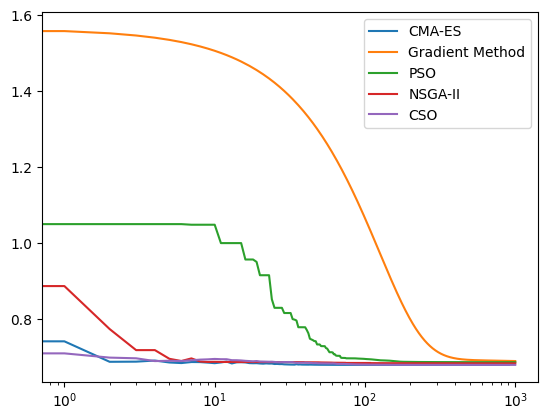

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_cma, label="CMA-ES")
plt.plot(loss_grad, label="Gradient Method")
plt.plot(loss_pso, label="PSO")
plt.plot(loss_nsga, label="NSGA-II")
plt.plot(loss_cso, label="CSO")
plt.legend()
plt.xscale("log")

In [ ]:
w_cma

array([-0.33808536, -0.09316605,  0.39369583,  0.1358864 ,  0.2515358 ,
        0.38412996, -0.01348105, -0.05196196, -0.37224236,  0.03913442,
        0.05902845])

In [ ]:
w_grad

array([ 0.31559464,  0.06103946,  0.08793883,  0.41110784,  0.37429271,
       -0.01625912, -0.08887394,  0.01098135,  0.04514707,  0.01465092,
       -0.38294621])

In [ ]:
w_pso

array([-0.38837835,  0.66833247,  0.55227376,  0.03416105,  0.31652916,
        0.45172032, -0.03322396, -0.14008896, -0.39633934, -0.26528365,
       -0.16727063])

In [ ]:
w_nsga

array([2.52414421e-04, 3.86121126e-04, 2.08815520e-01, 3.34368399e-03,
       9.39548061e-02, 2.00920517e-01, 3.43997077e-03, 2.01181488e-04,
       1.94428945e-03, 5.95174130e-05, 1.17802852e-03])

In [ ]:
w_cso

array([-0.33995543, -0.0933929 ,  0.39527253,  0.13642162,  0.25057685,
        0.38424742, -0.01397299, -0.05201689, -0.37146392,  0.04098867,
        0.05799583])

# Real data

Раздел со сравнением работы алгоритма на реальном датасете

Были выбраны два датасета https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction и https://www.kaggle.com/datasets/ilyazawilsiv/it-vacancies-from-headhunter-website. Второй датасет представляет из себя описания вакансий с сайта hh.ru. Для текста были получены эмбединги размерности 300. Необходимо предсказать будет ли зарплата больше 150_000 или нет. Первый датасет связан с предсказанием остановки сердца. Всего в нем 10 фичей.

Необходимо сравнить работу алгоритмов на датасетах разной размерности


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import time

In [ ]:
data_heart = pd.read_csv("Heart Failure Prediction.csv")
data_heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
data_heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
# One-hot encoding
data_heart_dum = pd.get_dummies(
    data_heart,
    columns=data_heart.select_dtypes(include=["object"]).columns,
    dtype=int)
data_heart_dum.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_heart_dum.drop(["HeartDisease"], axis=1),
    data_heart_dum["HeartDisease"],
    test_size=0.3,
    stratify=data_heart_dum["HeartDisease"],
)
print(f"data shape {X_train.shape}, target shape {y_train.shape}")

data shape (642, 20), target shape (642,)


In [ ]:
scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

In [ ]:
# Gradient
w_0 = np.random.random(X_train.shape[1] + 1)
w_grad, loss_grad = train_Log_Reg_gradient_method(
    X_train, y_train, w_0, lr=0.0001, num_epoch=400
)
y_pred = Logistic_Regression(X_test, w_grad)
recall_score(y_test, list(map(int, y_pred > 0.5)))

0.9215686274509803

In [ ]:
# CMA-ES
w_cma, loss_cma = purecmaes(X_train, y_train, use_mean=True, stopeval=5000)
y_pred = Logistic_Regression(X_test, w_cma)
recall_score(y_test, list(map(int, y_pred > 0.5)))

0.9150326797385621

In [ ]:
# PSO
w_pso, loss_pso = PSO(X_train, y_train, -5, 5, num_perticles=20, num_iter=400)
y_pred = Logistic_Regression(X_test, w_pso)
recall_score(y_test, list(map(int, y_pred > 0.5)))

0.9215686274509803

In [ ]:
# NSGA-II
w_nsga, history = nsga_ii(X_train, y_train, num_generations=400)
loss_nsga = [np.min(scores) for _, scores in history]
y_pred_nsga = Logistic_Regression(X_test, w_nsga)
recall_score(y_test, list(map(int, y_pred_nsga > 0.5)))

0.9281045751633987

In [ ]:
# CSO
w_cso, loss_cso = CSO(fitness_func=Logistic_Regression,
                       dim=X_train.shape[1] + 1,
                       X=X_train,
                       y=y_train,
                       population_size=20,
                       seeking_memory_pool=5,
                       dimension_masking_prob=0.3,
                       mixing_ratio=0.1,
                       max_iterations=400)

y_pred = Logistic_Regression(X_test, w_cso)
recall_score(y_test, list(map(int, y_pred > 0.5)))

  0%|          | 0/400 [00:00<?, ?it/s]

0.9150326797385621

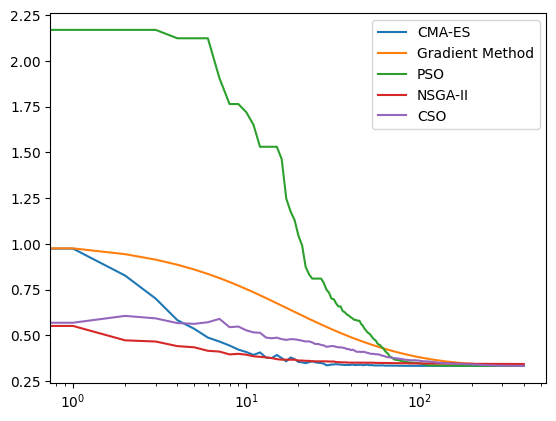

In [ ]:
plt.plot(loss_cma, label="CMA-ES")
plt.plot(loss_grad, label="Gradient Method")
plt.plot(loss_pso, label="PSO")
plt.plot(loss_nsga, label="NSGA-II")
plt.plot(loss_cso, label="CSO")
plt.legend()
plt.xscale("log")

In [ ]:
def compare_iter(
    X_train,
    X_test,
    y_train,
    y_test,
    num_iter=20,
    lr=0.0001,
    num_epoch=400,
    stopeval=5000,
    num_perticles=20,
):
    compare = []
    timing = []

    for i in tqdm(range(num_iter)):
        # Gradient
        w_0 = np.random.random(X_train.shape[1] + 1)
        start_time = time.time()
        w_grad, _ = train_Log_Reg_gradient_method(
            X_train, y_train, w_0, lr=lr, num_epoch=num_epoch
        )
        time_taken_grad = time.time() - start_time
        y_pred = Logistic_Regression(X_test, w_grad)
        loss_grad = Log_Loss(y_test, y_pred)
        # CMA-ES
        start_time = time.time()
        w_cma, _ = purecmaes(X_train, y_train, use_mean=True, stopeval=stopeval)
        time_taken_cma = time.time() - start_time
        y_pred = Logistic_Regression(X_test, w_cma)
        loss_cma = Log_Loss(y_test, y_pred)

        # PSO
        start_time = time.time()
        w_pso, _ = PSO(
            X_train, y_train, -5, 5, num_perticles=num_perticles, num_iter=num_epoch
        )
        time_taken_pso = time.time() - start_time
        y_pred = Logistic_Regression(X_test, w_pso)
        loss_pso = Log_Loss(y_test, y_pred)

        # NSGA-II
        start_time = time.time()
        w_nsga, _ = nsga_ii(X_train, y_train, num_generations=num_epoch)
        time_taken_nsga = time.time() - start_time
        y_pred = Logistic_Regression(X_test, w_nsga)
        loss_nsga = Log_Loss(y_test, y_pred)

        # CSO
        start_time = time.time()
        w_cso, _ = CSO(fitness_func=Logistic_Regression,
                       dim=X_train.shape[1] + 1,
                       X=X_train,
                       y=y_train,
                       population_size=20,
                       seeking_memory_pool=5,
                       dimension_masking_prob=0.3,
                       mixing_ratio=0.1,
                       max_iterations=num_epoch,
                       learning_rate=lr)
        time_taken_cso = time.time() - start_time
        y_pred = Logistic_Regression(X_test, w_cso)
        loss_cso = Log_Loss(y_test, y_pred)

        compare.append([loss_grad, loss_cma, loss_pso, loss_nsga, loss_cso])
        timing.append([time_taken_grad, time_taken_cma, time_taken_pso, time_taken_nsga, time_taken_cso])

    return compare, timing

compare, timing = compare_iter(X_train, X_test, y_train, y_test)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
!pip install scikit_posthocs

In [ ]:
import scikit_posthocs as sp

data = np.array(compare)
cols = ["Grad", "CMA-ES", "PSO", "NSGA-II", "CSO"]

# Conduct the Nemenyi post-hoc test
test = sp.posthoc_nemenyi_friedman(data)
test.columns = cols
test.index = cols
test

,Grad,CMA-ES,PSO,NSGA-II,CSO
Grad,1.000000,0.022661,0.001000,0.001000,0.022661
CMA-ES,0.022661,1.000000,0.040902,0.002015,0.900000
PSO,0.001000,0.040902,1.000000,0.894578,0.040902
NSGA-II,0.001000,0.002015,0.894578,1.000000,0.002015
CSO,0.022661,0.900000,0.040902,0.002015,1.000000


In [ ]:
# loss
dict(zip(cols, data.mean(axis=0)))

{'Grad': 0.3139739373485429,
 'CMA-ES': 0.3164062893435896,
 'PSO': 0.3431450405114279,
 'NSGA-II': 0.33272499347006795,
 'CSO': 0.3164229517802075}

In [ ]:
# timing
dict(zip(cols, np.mean(timing, axis=0)))

{'Grad': 0.757213580608368,
 'CMA-ES': 6.64282534122467,
 'PSO': 8.721125960350037,
 'NSGA-II': 46.37666401863098,
 'CSO': 49.35033901929855}

In [ ]:
# эмбединги
data_emb = pd.read_csv("data_emb.csv")
data_emb.shape

(3405, 301)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_emb.drop(["target"], axis=1),
    data_emb["target"],
    test_size=0.3,
    stratify=data_emb["target"],
)
print(f"data shape {X_train.shape}, target shape {y_train.shape}")

data shape (2383, 300), target shape (2383,)


In [ ]:
scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

In [ ]:
# Gradient
w_0 = np.random.random(X_train.shape[1] + 1)
w_grad, loss_grad = train_Log_Reg_gradient_method(X_train,
                                                  y_train,
                                                  w_0,
                                                  lr=0.0001,
                                                  num_epoch=400)
y_pred = Logistic_Regression(X_test, w_grad)
recall_score(y_test, list(map(int, y_pred > 0.5)))

0.4489247311827957

In [ ]:
# CMA-ES
w_cma, loss_cma = purecmaes(X_train, y_train, use_mean=True, stopeval=8000)
y_pred = Logistic_Regression(X_test, w_cma)
recall_score(y_test, list(map(int, y_pred > 0.5)))

0.48655913978494625

In [ ]:
# PSO
w_pso, loss_pso = PSO(X_train, y_train, -5, 5, num_perticles=20, num_iter=400)
y_pred = Logistic_Regression(X_test, w_pso)
recall_score(y_test, list(map(int, y_pred > 0.5)))

0.5564516129032258

In [ ]:
# NSGA-II
w_nsga, history = nsga_ii(X_train, y_train, num_generations=400)
loss_nsga = [np.min(scores) for _, scores in history]
y_pred_nsga = Logistic_Regression(X_test, w_nsga)
recall_score(y_test, list(map(int, y_pred_nsga > 0.5)))

0.5887096774193549

In [ ]:
# CSO
w_cso, loss_cso = CSO(fitness_func=Logistic_Regression,
                       dim=X_train.shape[1] + 1,
                       X=X_train,
                       y=y_train,
                       population_size=20,
                       seeking_memory_pool=5,
                       dimension_masking_prob=0.3,
                       mixing_ratio=0.1,
                       max_iterations=400)

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
y_pred_nsga = Logistic_Regression(X_test, w_cso)
recall_score(y_test, list(map(int, y_pred_nsga > 0.5)))

0.4731182795698925

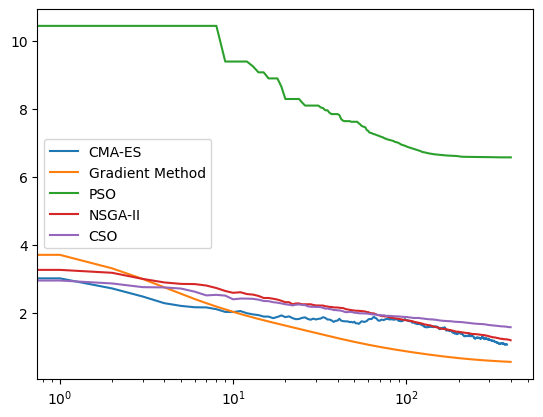

In [ ]:
plt.plot(loss_cma, label="CMA-ES")
plt.plot(loss_grad, label="Gradient Method")
plt.plot(loss_pso, label="PSO")
plt.plot(loss_nsga, label="NSGA-II")
plt.plot(loss_cso, label="CSO")
plt.legend()
plt.xscale("log")

In [ ]:
compare, timing = compare_iter(X_train, X_test, y_train, y_test, stopeval=8000)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encounter

  0%|          | 0/400 [00:00<?, ?it/s]

<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))


  0%|          | 0/400 [00:00<?, ?it/s]

<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))


  0%|          | 0/400 [00:00<?, ?it/s]

<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))
<ipython-input-2-024e4ee4e1fc>:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-add_const(X).dot(w) + eps))


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
import scikit_posthocs as sp

data = np.array(compare)
cols = ["Grad", "CMA-ES", "PSO", "NSGA-II", "CSO"]

# Conduct the Nemenyi post-hoc test
test = sp.posthoc_nemenyi_friedman(data)
test.columns = cols
test.index = cols
test

,Grad,CMA-ES,PSO,NSGA-II,CSO
Grad,1.000000,0.001000,0.001000,0.220004,0.001000
CMA-ES,0.001000,1.000000,0.001000,0.374437,0.220004
PSO,0.001000,0.001000,1.000000,0.001000,0.265918
NSGA-II,0.220004,0.374437,0.001000,1.000000,0.001000
CSO,0.001000,0.220004,0.265918,0.001000,1.000000


In [ ]:
# loss
dict(zip(cols, data.mean(axis=0)))

{'Grad': 0.7210835540657414,
 'CMA-ES': 1.3973769690496074,
 'PSO': 7.474165216103837,
 'NSGA-II': 1.230407995906298,
 'CSO': 1.8406399898597439}

In [ ]:
# timing
dict(zip(cols, np.mean(timing, axis=0)))

{'Grad': 1.925175094604492,
 'CMA-ES': 29.388109743595123,
 'PSO': 21.666622149944306,
 'NSGA-II': 107.23922264575958,
 'CSO': 117.43944762945175}